In [1485]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pprint

from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.neural_network import MLPClassifier as SKMLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from typing import List
from enum import Enum

pp = pprint.PrettyPrinter(indent=4, depth=4)

# Salary Classification


## 3.1 Exploratory Data Analysis - EDA

In [1486]:
full_relative_path = "tema2_SalaryPrediction/SalaryPrediction_full.csv"
train_relative_path = "tema2_SalaryPrediction/SalaryPrediction_train.csv"
test_relative_path = "tema2_SalaryPrediction/SalaryPrediction_test.csv"

salary_df = pd.read_csv(full_relative_path)
salary_train_df = pd.read_csv(train_relative_path)
salary_test_df = pd.read_csv(test_relative_path)

# Print the first 10 rows to check if the data has been loaded and what features are present
salary_df.head(10)

,fnl,hpw,relation,gain,country,job,edu_int,years,loss,work_type,partner,edu,gender,race,prod,gtype,money
0,264627,40.0,NotM,0,United-States,Adm-clerical,10,38,0,Priv,D,SC,NaN,White,77,DC,<=50K
1,151369,40.0,NotF,0,United-States,Craft-repair,9,62,0,LGov,NM,HSG,M,White,87,AC,<=50K
2,188615,60.0,H,0,United-States,Sales,13,42,0,SelfInc,MCS,B,M,White,77,AC,>50K
3,151089,55.0,H,0,United-States,Exec-managerial,10,41,2415,SelfInc,MCS,SC,M,White,107,AC,>50K
4,177625,40.0,NotF,0,United-States,Machine-op-inspct,9,25,0,Priv,NM,HSG,M,White,57,AC,<=50K
5,444089,40.0,NotF,0,United-States,Sales,7,56,0,Priv,D,11,F,White,62,DC,<=50K
6,101320,75.0,NotF,0,United-States,Exec-managerial,14,49,0,Priv,D,M,F,White,62,DC,<=50K
7,35411,40.0,NotF,0,United-States,Machine-op-inspct,9,59,0,Priv,W,HSG,F,White,82,DC,<=50K
8,93235,25.0,OwnC,0,United-States,Other-service,8,17,1721,Priv,NM,12,F,White,67,DC,<=50K
9,232855,37.0,NotM,0,United-States,Other-service,10,34,0,Priv,S,SC,F,Black,52,DC,<=50K


In [1487]:
# Check the shape of the dataframe
print(salary_df.shape)

(9999, 17)


In [1488]:
# Data type for each column
for col in salary_df.columns:
    print(col, "is of type", type(salary_df[col][0]))

fnl is of type <class 'numpy.int64'>
hpw is of type <class 'numpy.float64'>
relation is of type <class 'str'>
gain is of type <class 'numpy.int64'>
country is of type <class 'str'>
job is of type <class 'str'>
edu_int is of type <class 'numpy.int64'>
years is of type <class 'numpy.int64'>
loss is of type <class 'numpy.int64'>
work_type is of type <class 'str'>
partner is of type <class 'str'>
edu is of type <class 'str'>
gender is of type <class 'float'>
race is of type <class 'str'>
prod is of type <class 'numpy.int64'>
gtype is of type <class 'str'>
money is of type <class 'str'>


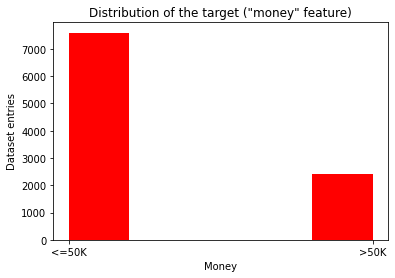

'We may observe that there is a lot more data for <= 50k salaries'

In [1489]:
# Analyzing the target feature
target = salary_df['money']

plt.hist(target, color = 'red', bins = 5)
plt.xlabel('Money')
plt.ylabel('Dataset entries')
plt.title('Distribution of the target ("money" feature)')
plt.show()

"""We may observe that there is a lot more data for <= 50k salaries"""

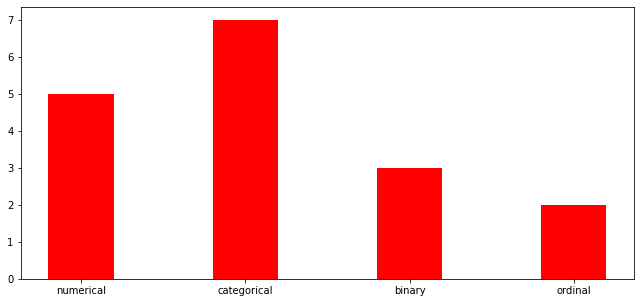

{   'binary': {'attributes': ['gender', 'gtype', 'money'], 'size': 3},
    'categorical': {   'attributes': [   'relation',
                                         'country',
                                         'job',
                                         'work_type',
                                         'partner',
                                         'edu',
                                         'race'],
                       'size': 7},
    'numerical': {   'attributes': ['fnl', 'hpw', 'gain', 'loss', 'prod'],
                     'size': 5},
    'ordinal': {'attributes': ['edu_int', 'years'], 'size': 2}}


In [1490]:
def get_features_types(df, dataset="Salary"):
    types = ["numerical", "categorical", "binary", "ordinal"]
    features = {k: {"attributes": [], "size": 0} for k in types}

    if dataset == "Salary":
        # Considering "edu_int" and "years" to be ordinal features  (by manual inspecting the dataframe)
        features["ordinal"] = {"attributes": ["edu_int", "years"], "size": 2}
    elif dataset == "AVC":
        features["ordinal"] = {"attributes": ["years_old"], "size": 1}

    for col in df.columns:
        if col in features["ordinal"]["attributes"]:
            continue

        if df[col].nunique() == 2:
            type = "binary"
        elif pd.api.types.is_numeric_dtype(df[col]):
            type = "numerical"
        else:
            type = "categorical"
        
        features[type]["attributes"].append(col)
        features[type]["size"] += 1

    return features

features = get_features_types(salary_df)

plt.figure(figsize = (11, 5))
plt.bar(features.keys(), [v["size"] for v in features.values()], width = .4, color = 'red')
plt.show()

pp.pprint(features)

### Numerical features - including ordinal features

In [1491]:
numerical_combined_stats_df = pd.DataFrame()

for numerical_feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    statistics = salary_df[numerical_feature].describe(percentiles=[0.25, 0.5, 0.75]).T
    missing = salary_df[numerical_feature].isnull().sum()
    
    # Combine statistics and missing values
    stats_dict = {
        'num_examples': statistics['count'],
        'mean': statistics['mean'],
        'std_dev': statistics['std'],
        'min': statistics['min'],
        '25th_percentile': statistics['25%'],
        'median': statistics['50%'],
        '75th_percentile': statistics['75%'],
        'max': statistics['max'],
        'missing': missing
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[numerical_feature])
    numerical_combined_stats_df = pd.concat([numerical_combined_stats_df, stats_df])

display(numerical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'mean': '{:,.2f}',
    'std_dev': '{:,.2f}',
    'min': '{:,.2f}',
    '25th_percentile': '{:,.2f}',
    'median': '{:,.2f}',
    '75th_percentile': '{:,.2f}',
    'max': '{:,.2f}',
    'missing': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,mean,std_dev,min,25th_percentile,median,75th_percentile,max,missing
fnl,"9,999","190,352.90","106,070.86","19,214.00","118,282.50","178,472.00","237,311.00","1,455,435.00",0
hpw,"9,199",40.42,12.52,1.00,40.00,40.00,45.00,99.00,800
gain,"9,999",979.85,"7,003.80",0.00,0.00,0.00,0.00,"99,999.00",0
loss,"9,999",84.11,394.04,0.00,0.00,0.00,0.00,"3,770.00",0
prod,"9,999","2,014.93","14,007.60",-28.00,42.00,57.00,77.00,"200,125.00",0
edu_int,"9,999",14.26,24.77,1.00,9.00,10.00,13.00,206.00,0
years,"9,999",38.65,13.75,17.00,28.00,37.00,48.00,90.00,0


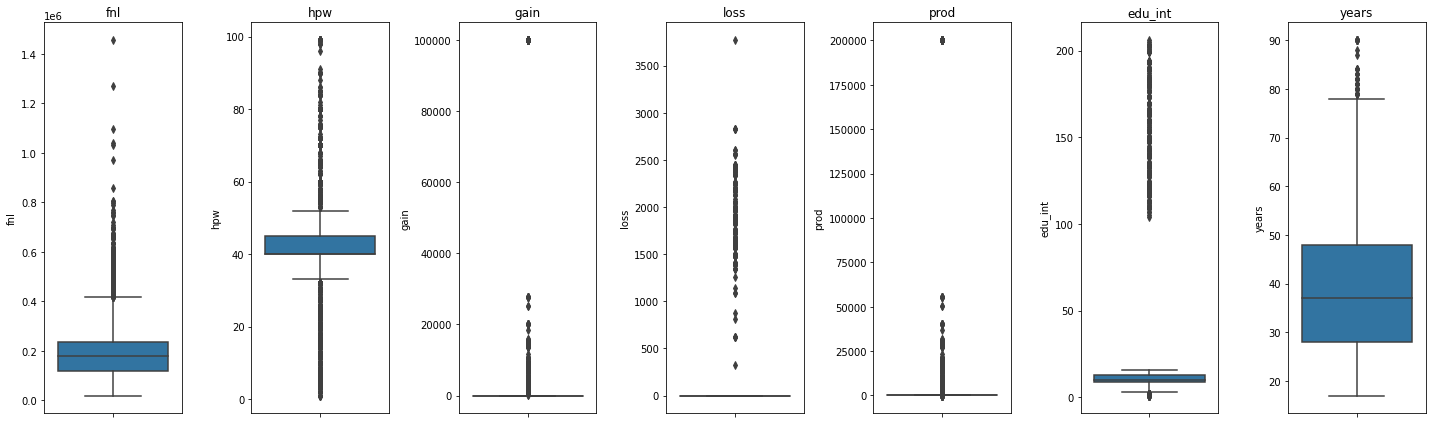

In [1492]:
# Create subplots for boxplots
def print_numerical_features_boxplots(df, features):
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 6))

    for i, numerical_feature in enumerate(features):
        sns.boxplot(data=df, y=numerical_feature, ax=axes[i])
        axes[i].set_title(numerical_feature)

    plt.tight_layout()
    plt.show()
    
print_numerical_features_boxplots(salary_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

### Categorical Features - including binary features

In [1493]:
categorical_combined_stats_df = pd.DataFrame()

for categorical_feature in features["categorical"]["attributes"] + features["binary"]["attributes"]:
    non_missing_count = salary_df[categorical_feature].notnull().sum()
    unique_count = salary_df[categorical_feature].nunique()
    
    # Combine statistics into a dictionary
    stats_dict = {
        'num_examples': non_missing_count,
        'num_unique': unique_count
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[categorical_feature])
    categorical_combined_stats_df = pd.concat([categorical_combined_stats_df, stats_df])

display(categorical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'num_unique': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,num_unique
relation,"9,999",6
country,"9,999",41
job,"9,999",14
work_type,"9,999",9
partner,"9,999",7
edu,"9,999",16
race,"9,999",5
gender,"9,199",2
gtype,"9,999",2
money,"9,999",2


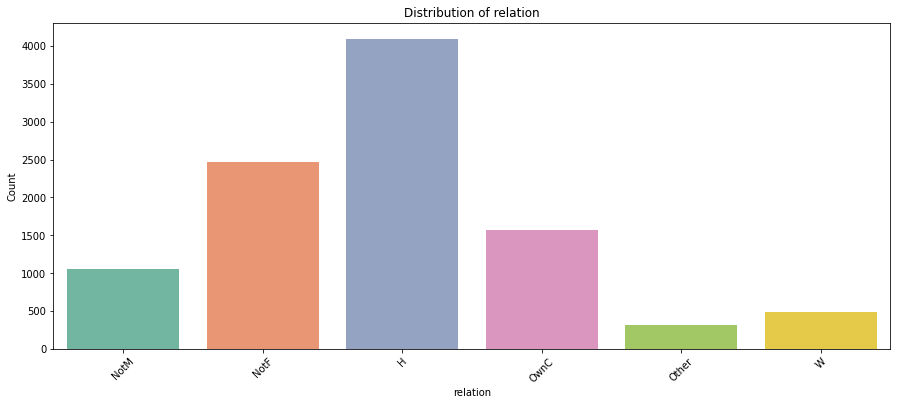

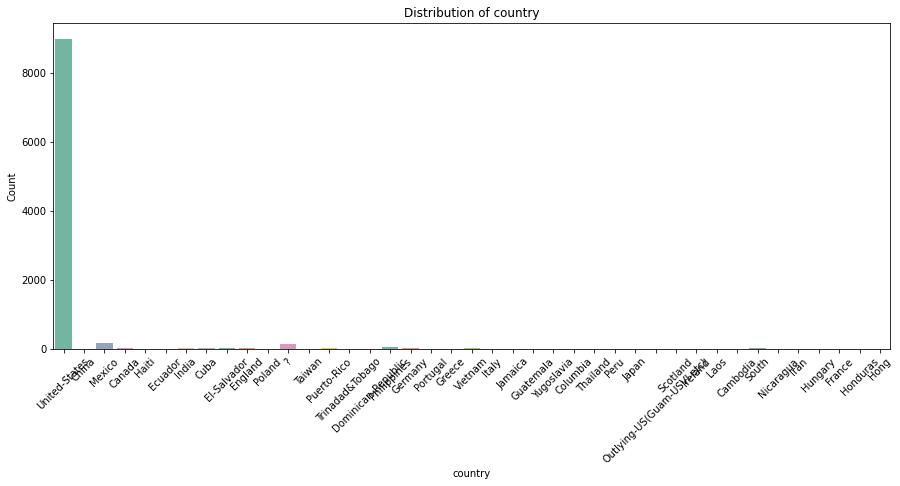

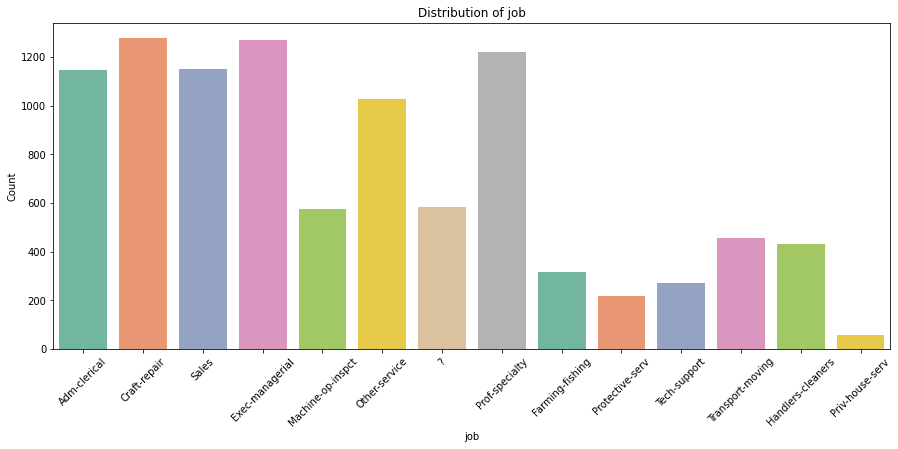

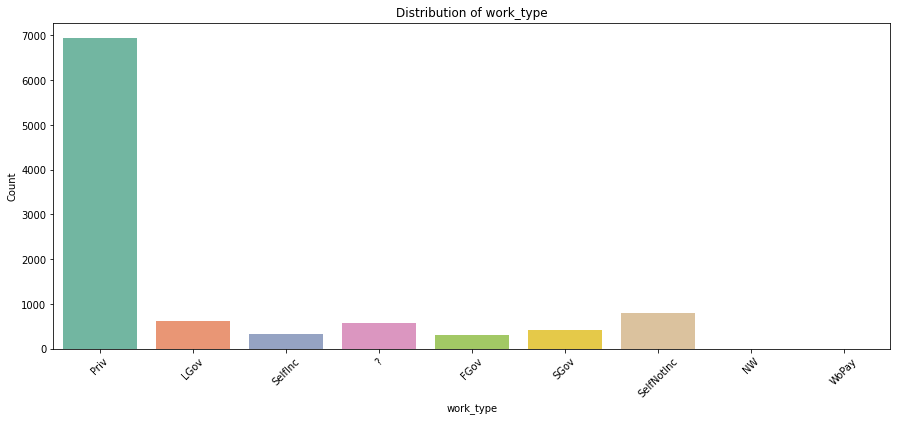

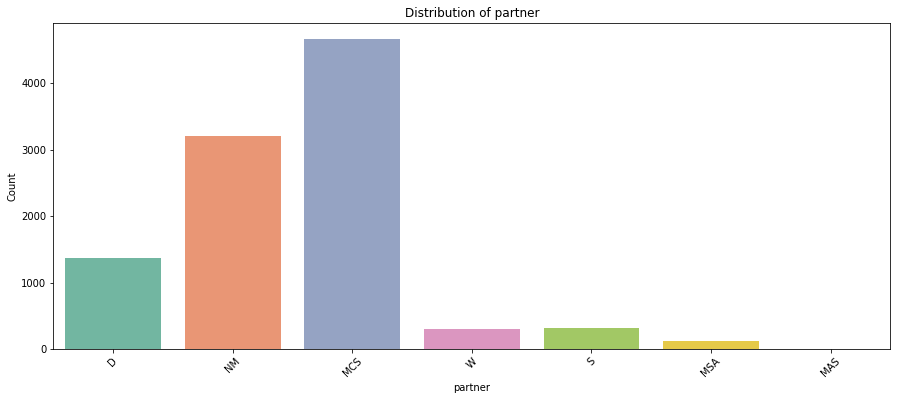

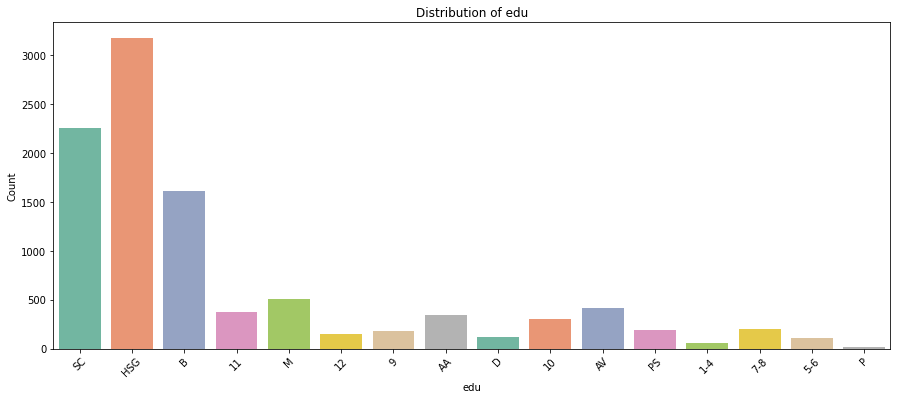

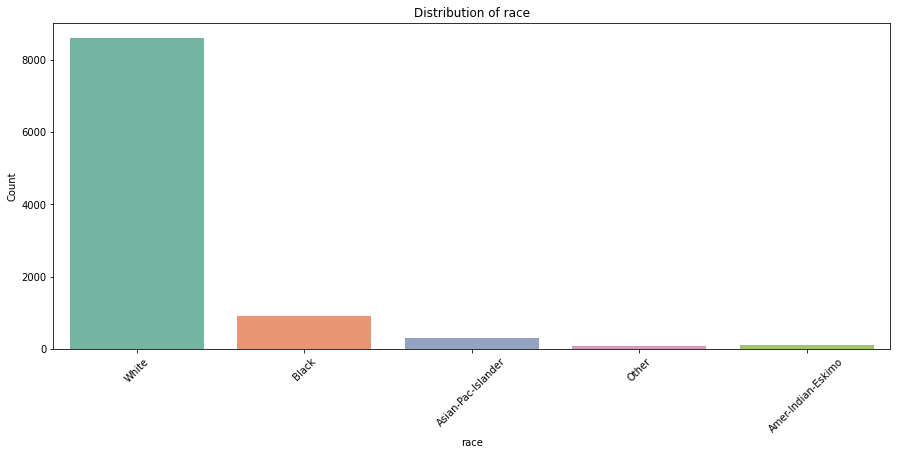

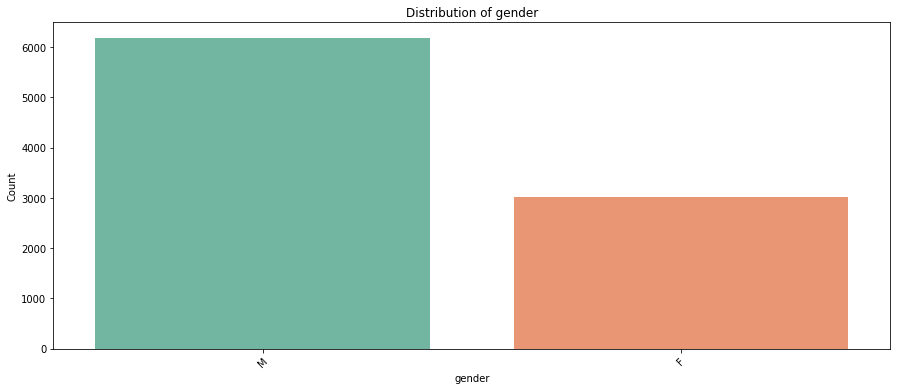

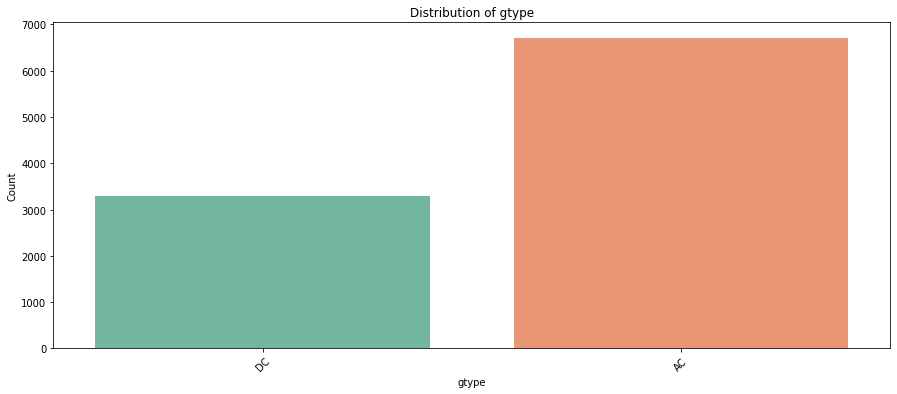

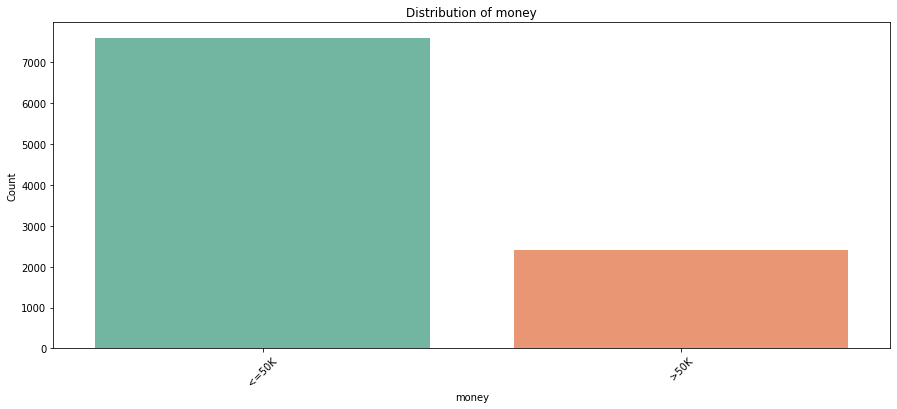

In [1494]:
for feature in features["categorical"]["attributes"] + features["binary"]["attributes"]:
    plt.figure(figsize=(15, 6))
    sns.countplot(data=salary_df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

### 3.1.2 Correlation Analysis

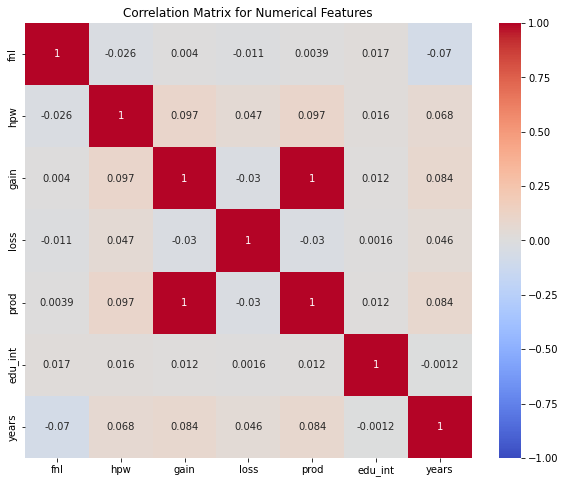

In [1495]:
# Numerical features - including ordinal features
corr_matrix = salary_df[features["numerical"]["attributes"] + features["ordinal"]["attributes"]].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

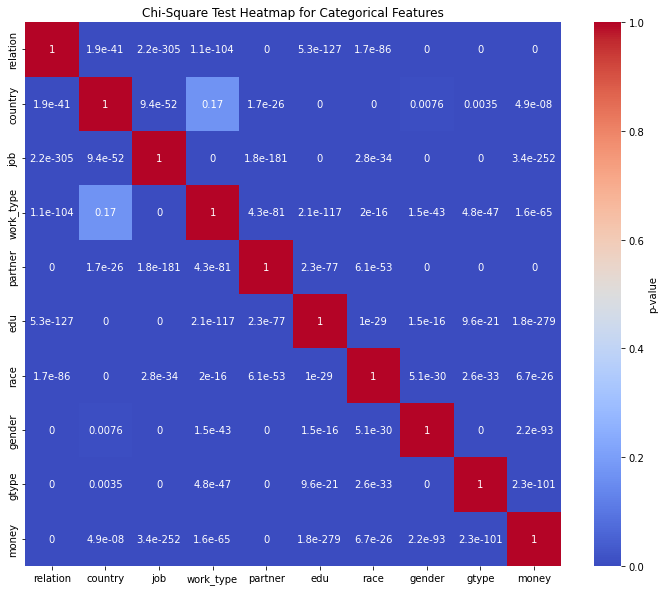

In [1496]:
cat_attributes = features["categorical"]["attributes"] + features["binary"]["attributes"]

# chi_square lambda function to be used for finding correlations between categorical features
chi_square = lambda df, f1, f2: chi2_contingency(pd.crosstab(df[f1], df[f2]))[1]
categorical_corr = pd.DataFrame(np.ones((len(cat_attributes), len(cat_attributes))),
                                index=cat_attributes, columns=cat_attributes)

for f1, f2 in list(filter(lambda f: f[0] != f[1], list(itertools.product(cat_attributes, repeat=2)))):
    categorical_corr.at[f1, f2] = categorical_corr.at[f2, f1] = chi_square(salary_df, f1, f2)

plt.figure(figsize=(12, 10))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'p-value'})
plt.title('Chi-Square Test Heatmap for Categorical Features')
plt.show()


## 3.2 Data preprocessing

#### 3.2.1 Missing values

There are just two features with missing values - hpw and gender.

In [1497]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fill the missing values from hpw with mean value
salary_df['hpw'] = simple_imputer.fit_transform(salary_df['hpw'].values.reshape(-1, 1))
salary_train_df['hpw'] = simple_imputer.fit_transform(salary_train_df['hpw'].values.reshape(-1, 1))
salary_test_df['hpw'] = simple_imputer.fit_transform(salary_test_df['hpw'].values.reshape(-1, 1))

In [1498]:
# For gender, it is a wild guess to fill the missing values with the most common value, so we will drop the rows
salary_df = salary_df.dropna(subset=["gender"])
salary_train_df = salary_train_df.dropna(subset=["gender"])
salary_test_df = salary_test_df.dropna(subset=["gender"])

#### 3.2.2 Extreme values - Outliers

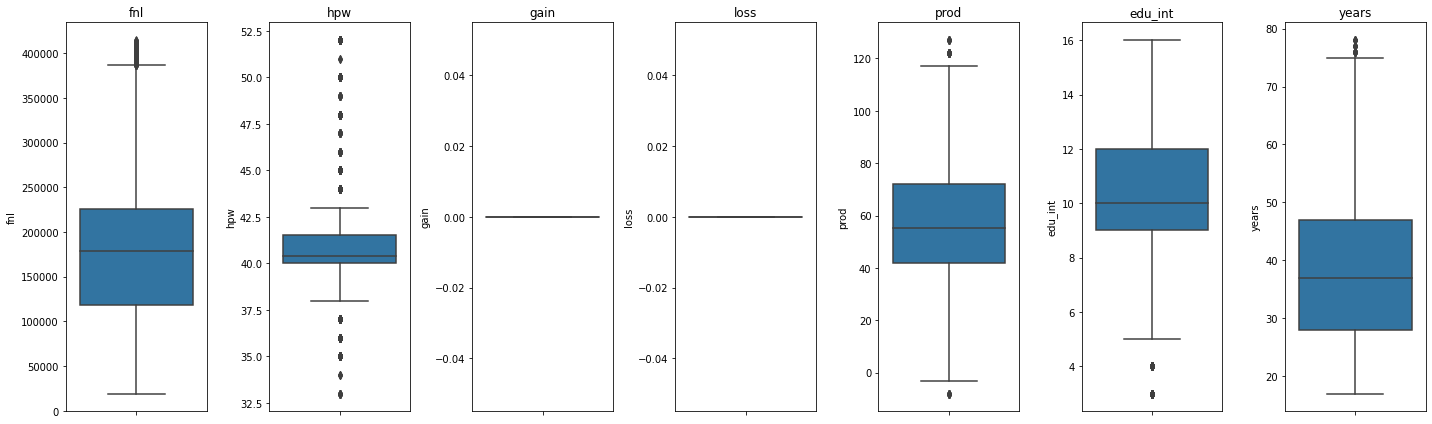

In [1499]:
def outliers(df, feature):
    Q_low = df[feature].quantile(0.25)
    Q_high = df[feature].quantile(0.75)
    IQR = Q_high - Q_low
    upper_limit = Q_high + 1.5 * IQR
    lower_limit = Q_low - 1.5 * IQR

    # Use SimpleImputer to fill the outliers with the mean value
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    # Assign np.nan to the outliers
    df.loc[(df[feature] < lower_limit) | (df[feature] > upper_limit), feature] = np.nan
    
    # Fill the outliers with the mean value
    df[feature] = imputer.fit_transform(df[feature].values.reshape(-1, 1))
    
    return df

for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    salary_df = outliers(salary_df, feature)
    salary_train_df = outliers(salary_train_df, feature)
    salary_test_df = outliers(salary_test_df, feature)
    
print_numerical_features_boxplots(salary_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

#### 3.2.3 Removing the redundant features - strongly correlated features

In [1500]:
# For work_type, all that contain "gov" transform to "Gov" and all that contain "Self" put under "Self"
salary_df['work_type'] = salary_df['work_type'].apply(lambda x: 'Gov' if 'gov' in x.lower() else 'Self' if 'self' in x.lower() else x)
salary_train_df["work_type"] = salary_train_df["work_type"].apply(lambda x: 'Gov' if 'gov' in x.lower() else 'Self' if 'self' in x.lower() else x)
salary_test_df["work_type"] = salary_test_df["work_type"].apply(lambda x: 'Gov' if 'gov' in x.lower() else 'Self' if 'self' in x.lower() else x)

In [1501]:
removed_numerical_categories = ["gain"]
removed_categorical_categories = ["partner", "edu", "race", "gtype", "work_type"]

# For the numerical features, I will remove the "gain" feature, as it is strongly correlated to "prod"
# and does not bring any additional information
salary_df = salary_df.drop(columns = removed_numerical_categories)
salary_train_df = salary_train_df.drop(columns = removed_numerical_categories)
salary_test_df = salary_test_df.drop(columns = removed_numerical_categories)

# For the categorical features, I am going to remove the most obvious ones (where p-value is 0)
salary_df = salary_df.drop(columns = removed_categorical_categories)
salary_train_df = salary_train_df.drop(columns = removed_categorical_categories)
salary_test_df = salary_test_df.drop(columns = removed_categorical_categories)

# Also remove these from features
features["categorical"]["attributes"] = [feature for feature in features["categorical"]["attributes"] if feature not in removed_categorical_categories]
features["categorical"]["size"] = len(features["categorical"]["attributes"])

features["numerical"]["attributes"] = [feature for feature in features["numerical"]["attributes"] if feature not in removed_numerical_categories]
features["numerical"]["size"] = len(features["numerical"]["attributes"])
        
features["binary"]["attributes"] = [feature for feature in features["binary"]["attributes"] if feature not in removed_categorical_categories]
features["binary"]["size"] = len(features["binary"]["attributes"])

#### 3.2.4 Standardization for numerical features

RobustScaler may not be the best choice as the outliers have been removed.
MinMaxScaler may not be the best choice as the data is not normally distributed, and a normalization is required.
StandardScaler is the best choice for this dataset, suitable for the logistic regression and for features with different scales.

In [1502]:
standard_scaler = StandardScaler()

for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    salary_df[feature] = standard_scaler.fit_transform(salary_df[feature].values.reshape(-1, 1))
    salary_train_df[feature] = standard_scaler.fit_transform(salary_train_df[feature].values.reshape(-1, 1))
    salary_test_df[feature] = standard_scaler.fit_transform(salary_test_df[feature].values.reshape(-1, 1))

# min_max_scaler = MinMaxScaler()

# for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
#     salary_df[feature] = normalize(salary_df[feature].values.reshape(-1, 1))
#     salary_train_df[feature] = normalize(salary_train_df[feature].values.reshape(-1, 1))
#     salary_test_df[feature] = normalize(salary_test_df[feature].values.reshape(-1, 1))

#     salary_df[feature] = min_max_scaler.fit_transform(salary_df[feature].values.reshape(-1, 1))
#     salary_train_df[feature] = min_max_scaler.transform(salary_train_df[feature].values.reshape(-1, 1))
#     salary_test_df[feature] = min_max_scaler.transform(salary_test_df[feature].values.reshape(-1, 1))


#### Feature creation for "country"

There are 40 unique non-US countries


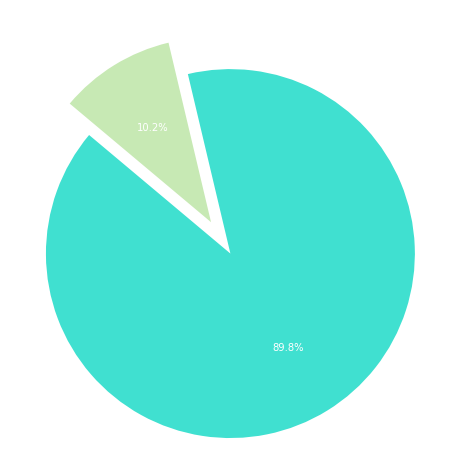

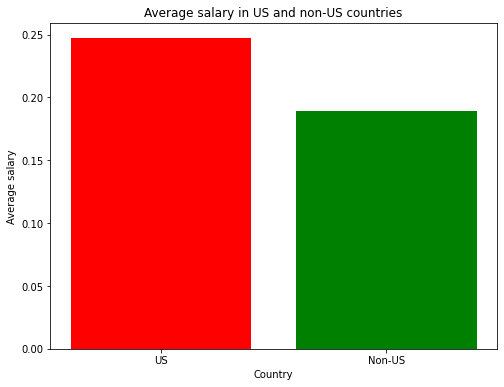

In [1503]:
if "country" in salary_df.columns:
    us_entries = salary_df[salary_df['country'] == 'United-States']
    non_us_entries = salary_df[salary_df['country'] != 'United-States']
    unique_non_us_countries = non_us_entries['country'].unique()

    print("There are {} unique non-US countries".format(len(unique_non_us_countries)))

    labels = ['US', 'Non-US']
    sizes = [us_entries.shape[0], non_us_entries.shape[0]]
    colors = ['#40E0D0', '#c7e9b4', '#EEE8AA']
    explode = [0.1, 0.1] 

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops=dict(color="white"))
    plt.title('Distribution of US and non US countries', color = "white")
    plt.axis('equal')
    plt.show()

    # Take all "money" values from us_entries and non_us_entries
    us_money_values = us_entries['money'].values
    non_us_money_values = non_us_entries['money'].values

    # Convert the >50k and <=50k values to 1 and 0
    us_money_values = np.where(us_money_values == '>50K', 1, 0)
    non_us_money_values = np.where(non_us_money_values == '>50K', 1, 0)

    # Calculate the mean based on the converted values
    average_us_salary = np.mean(us_money_values)
    average_non_us_salary = np.mean(non_us_money_values)

    plt.figure(figsize=(8, 6))
    plt.bar(['US', 'Non-US'], [average_us_salary, average_non_us_salary], color = ["red", "green"])
    plt.xlabel('Country')
    plt.ylabel('Average salary')
    plt.title('Average salary in US and non-US countries')
    plt.show()

#### Keypoints
* There are 40 non US countries and they represent only 10.2% of the entire dataset. It would be easy to categorize them as US and non US countries. Also, the mean salary for US is considerably higher than the mean salary for non US countries.

In [1504]:
if "country" in salary_df:
    # For the countries that are not United-States, replace their value with "Non-US"
    salary_df['country'] = salary_df['country'].apply(lambda x: 'Non-US' if x != 'United-States' else x)
    salary_train_df['country'] = salary_train_df['country'].apply(lambda x: 'Non-US' if x != 'United-States' else x)
    salary_test_df['country'] = salary_test_df['country'].apply(lambda x: 'Non-US' if x != 'United-States' else x)

#### 3.2.5 Encoding categorical features

In [1505]:
# For binary features, I will use the LabelEncoder - this includes the target feature
label_encoder = LabelEncoder()
for feature in features["binary"]["attributes"]:
    salary_df[feature] = label_encoder.fit_transform(salary_df[feature])
    salary_train_df[feature] = label_encoder.fit_transform(salary_train_df[feature])
    salary_test_df[feature] = label_encoder.fit_transform(salary_test_df[feature])
    
# For the categorical features with less than 20 unique values, I will use the OneHotEncoder
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)
for feature in features["categorical"]["attributes"]:
    if feature in salary_df:
        encoded = one_hot_encoder.fit_transform(salary_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_df = pd.DataFrame(encoded, columns=column_names)
        salary_df = pd.concat([salary_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
        salary_df = salary_df.drop(columns=[feature])

        encoded_train = one_hot_encoder.fit_transform(salary_train_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_train_df = pd.DataFrame(encoded_train, columns=column_names)
        salary_train_df = pd.concat([salary_train_df.reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)
        salary_train_df = salary_train_df.drop(columns=[feature])
        
        encoded_test = one_hot_encoder.fit_transform(salary_test_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_test_df = pd.DataFrame(encoded_test, columns=column_names)
        salary_test_df = pd.concat([salary_test_df.reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)
        salary_test_df = salary_test_df.drop(columns=[feature])
        
# Search for columns in salary_df that are not present in salary_train and salary_test and create those columns with zeros
for column in salary_df.columns:
    if column not in salary_train_df.columns:
        salary_train_df[column] = 0
    if column not in salary_test_df.columns:
        salary_test_df[column] = 0

# Sort the columns in the same order
salary_train_df = salary_train_df[salary_df.columns]
salary_test_df = salary_test_df[salary_df.columns]

salary_df

,fnl,hpw,edu_int,years,loss,gender,prod,money,relation_NotF,relation_NotM,...,job_Farming-fishing,job_Handlers-cleaners,job_Machine-op-inspct,job_Other-service,job_Priv-house-serv,job_Prof-specialty,job_Protective-serv,job_Sales,job_Tech-support,job_Transport-moving
0,-3.358385e-01,-0.454896,-0.446800,1.762997,0.0,1,1.353672,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.767175e-02,0.000000,1.185176,0.267679,0.0,1,0.928135,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-3.390974e-01,0.000000,-0.038806,0.192913,0.0,1,2.204746,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.024205e-02,-0.454896,-0.446800,-1.003341,0.0,1,0.077061,0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.387426e-16,-0.454896,-1.262788,1.314401,0.0,0,0.289830,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,8.454284e-02,-0.454896,-0.446800,1.463933,0.0,1,-1.412318,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9195,2.562847e+00,1.054643,-1.262788,-0.330448,0.0,1,0.077061,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9196,-1.083127e+00,0.000000,-1.262788,1.987294,0.0,0,1.140904,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9197,-1.834118e+00,1.054643,-0.446800,-0.704277,0.0,1,0.289830,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# AVC

## 3.1 Exploratory Data Analysis - EDA

In [1506]:
full_relative_path = "tema2_AVC/AVC_full.csv"
train_relative_path = "tema2_AVC/AVC_train.csv"
test_relative_path = "tema2_AVC/AVC_test.csv"

avc_df = pd.read_csv(full_relative_path)
avc_train_df = pd.read_csv(train_relative_path)
avc_test_df = pd.read_csv(test_relative_path)

# Print the first 10 rows to check if the data has been loaded and what features are present
avc_df.head(10)

,mean_blood_sugar_level,cardiovascular_issues,job_category,body_mass_indicator,sex,tobacco_usage,high_blood_pressure,married,living_area,years_old,chaotic_sleep,analysis_results,biological_age_index,cerebrovascular_accident
0,228.69,1,private_sector,36.6,M,ex-smoker,0,Y,City,67.0,1,503.662278,181.786614,1
1,202.21,0,entrepreneurial,NaN,F,non-smoker,0,Y,Countryside,61.0,0,503.541654,130.089915,1
2,105.92,1,private_sector,32.5,M,non-smoker,0,Y,Countryside,80.0,1,NaN,201.411374,1
3,171.23,0,private_sector,34.4,F,smoker,0,Y,City,49.0,0,411.618245,171.794024,1
4,174.12,0,entrepreneurial,24.0,F,non-smoker,1,Y,Countryside,79.0,0,450.887478,232.180890,1
5,186.21,0,private_sector,29.0,M,ex-smoker,0,Y,City,81.0,0,477.847257,237.595525,1
6,70.09,1,private_sector,27.4,M,non-smoker,1,Y,Countryside,74.0,1,276.197473,201.754472,1
7,94.39,0,private_sector,22.8,F,non-smoker,0,N,City,69.0,0,NaN,163.255207,1
8,76.15,0,private_sector,NaN,F,not_defined,0,Y,Countryside,59.0,0,NaN,182.246719,1
9,58.57,0,private_sector,24.2,F,not_defined,0,Y,City,78.0,0,302.467499,196.688263,1


### 3.1.1 Data Analysis and Visualization

In [1507]:
# Check the shape of the dataframe
print(avc_df.shape)

(5110, 14)


In [1508]:
# Data type for each column
for col in avc_df.columns:
    print(col, "is of type", type(avc_df[col][0]))

mean_blood_sugar_level is of type <class 'numpy.float64'>
cardiovascular_issues is of type <class 'numpy.int64'>
job_category is of type <class 'str'>
body_mass_indicator is of type <class 'numpy.float64'>
sex is of type <class 'str'>
tobacco_usage is of type <class 'str'>
high_blood_pressure is of type <class 'numpy.int64'>
married is of type <class 'str'>
living_area is of type <class 'str'>
years_old is of type <class 'numpy.float64'>
chaotic_sleep is of type <class 'numpy.int64'>
analysis_results is of type <class 'numpy.float64'>
biological_age_index is of type <class 'numpy.float64'>
cerebrovascular_accident is of type <class 'numpy.int64'>


249 people had CVA.


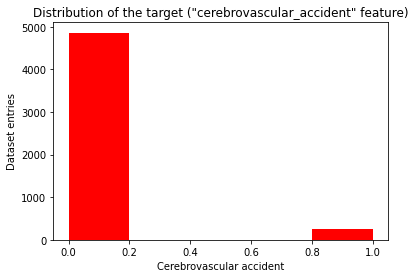

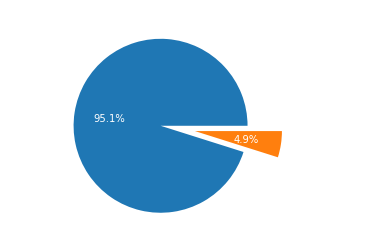

In [1509]:
# Analyzing the target feature
target = avc_df['cerebrovascular_accident']

had_cva = avc_df["cerebrovascular_accident"].sum()
print(f"{had_cva} people had CVA.")

plt.hist(target, color = 'red', bins = 5)
plt.xlabel('Cerebrovascular accident')
plt.ylabel('Dataset entries')
plt.title('Distribution of the target ("cerebrovascular_accident" feature)')
plt.show()

plt.title('Distribution of the target ("cerebrovascular_accident" feature)', color = "white")
my_xpl = [0.4] + [0.0] * (avc_df["cerebrovascular_accident"].nunique() - 1)
avc_df["cerebrovascular_accident"].value_counts().plot(kind='pie', explode=my_xpl, ylabel='', textprops=dict(color="white"), autopct='%1.1f%%')
plt.show()

We may observe that the majority of data is around the negative values of the predictor, meaning there is more data for the non-cerebrovascular accidents. This may imply some irregularities in the data, as the number of cerebrovascular accidents is not as high as the non-cerebrovascular accidents.

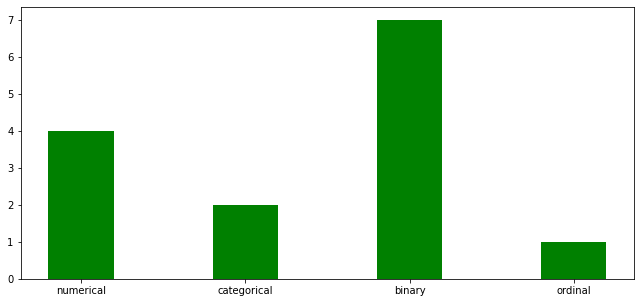

{   'binary': {   'attributes': [   'cardiovascular_issues',
                                    'sex',
                                    'high_blood_pressure',
                                    'married',
                                    'living_area',
                                    'chaotic_sleep',
                                    'cerebrovascular_accident'],
                  'size': 7},
    'categorical': {'attributes': ['job_category', 'tobacco_usage'], 'size': 2},
    'numerical': {   'attributes': [   'mean_blood_sugar_level',
                                       'body_mass_indicator',
                                       'analysis_results',
                                       'biological_age_index'],
                     'size': 4},
    'ordinal': {'attributes': ['years_old'], 'size': 1}}


In [1510]:
features = get_features_types(avc_df, "AVC")

plt.figure(figsize = (11, 5))
plt.bar(features.keys(), [v["size"] for v in features.values()], width = .4, color = 'green')
plt.show()

pp.pprint(features)

### Numerical features - including ordinal features

In [1511]:
numerical_combined_stats_df = pd.DataFrame()

for numerical_feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    statistics = avc_df[numerical_feature].describe(percentiles=[0.25, 0.5, 0.75]).T
    missing = avc_df[numerical_feature].isnull().sum()
    
    # Combine statistics and missing values
    stats_dict = {
        'num_examples': statistics['count'],
        'mean': statistics['mean'],
        'std_dev': statistics['std'],
        'min': statistics['min'],
        '25th_percentile': statistics['25%'],
        'median': statistics['50%'],
        '75th_percentile': statistics['75%'],
        'max': statistics['max'],
        'missing': missing
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[numerical_feature])
    numerical_combined_stats_df = pd.concat([numerical_combined_stats_df, stats_df])

display(numerical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'mean': '{:,.2f}',
    'std_dev': '{:,.2f}',
    'min': '{:,.2f}',
    '25th_percentile': '{:,.2f}',
    'median': '{:,.2f}',
    '75th_percentile': '{:,.2f}',
    'max': '{:,.2f}',
    'missing': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,mean,std_dev,min,25th_percentile,median,75th_percentile,max,missing
mean_blood_sugar_level,"5,110",106.15,45.28,55.12,77.25,91.88,114.09,271.74,0
body_mass_indicator,"4,909",28.89,7.85,10.30,23.50,28.10,33.10,97.60,201
analysis_results,"4,599",323.52,101.58,104.83,254.65,301.03,362.82,756.81,511
biological_age_index,"5,110",134.78,50.40,-15.11,96.71,136.37,172.51,266.99,0
years_old,"5,110",46.57,26.59,0.08,26.00,47.00,63.75,134.00,0


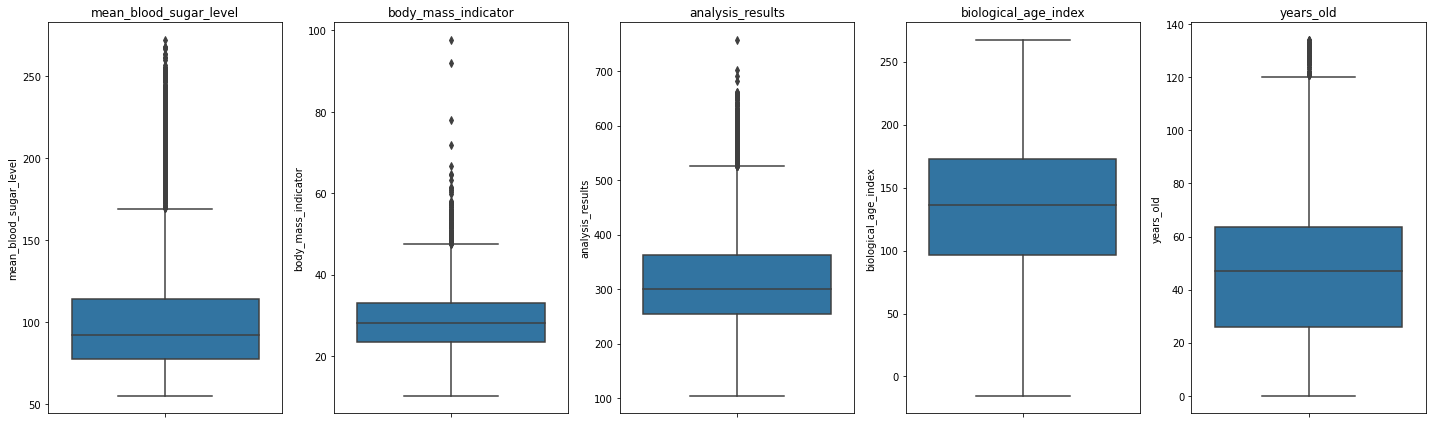

In [1512]:
print_numerical_features_boxplots(avc_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

### Categorical Features - including binary features

In [1513]:
categorical_combined_stats_df = pd.DataFrame()

for categorical_feature in features["categorical"]["attributes"] + features["binary"]["attributes"]:
    non_missing_count = avc_df[categorical_feature].notnull().sum()
    unique_count = avc_df[categorical_feature].nunique()
    
    # Combine statistics into a dictionary
    stats_dict = {
        'num_examples': non_missing_count,
        'num_unique': unique_count
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[categorical_feature])
    categorical_combined_stats_df = pd.concat([categorical_combined_stats_df, stats_df])

display(categorical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'num_unique': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))


,num_examples,num_unique
job_category,"5,110",5
tobacco_usage,"5,110",4
cardiovascular_issues,"5,110",2
sex,"5,110",2
high_blood_pressure,"5,110",2
married,"4,599",2
living_area,"5,110",2
chaotic_sleep,"5,110",2
cerebrovascular_accident,"5,110",2


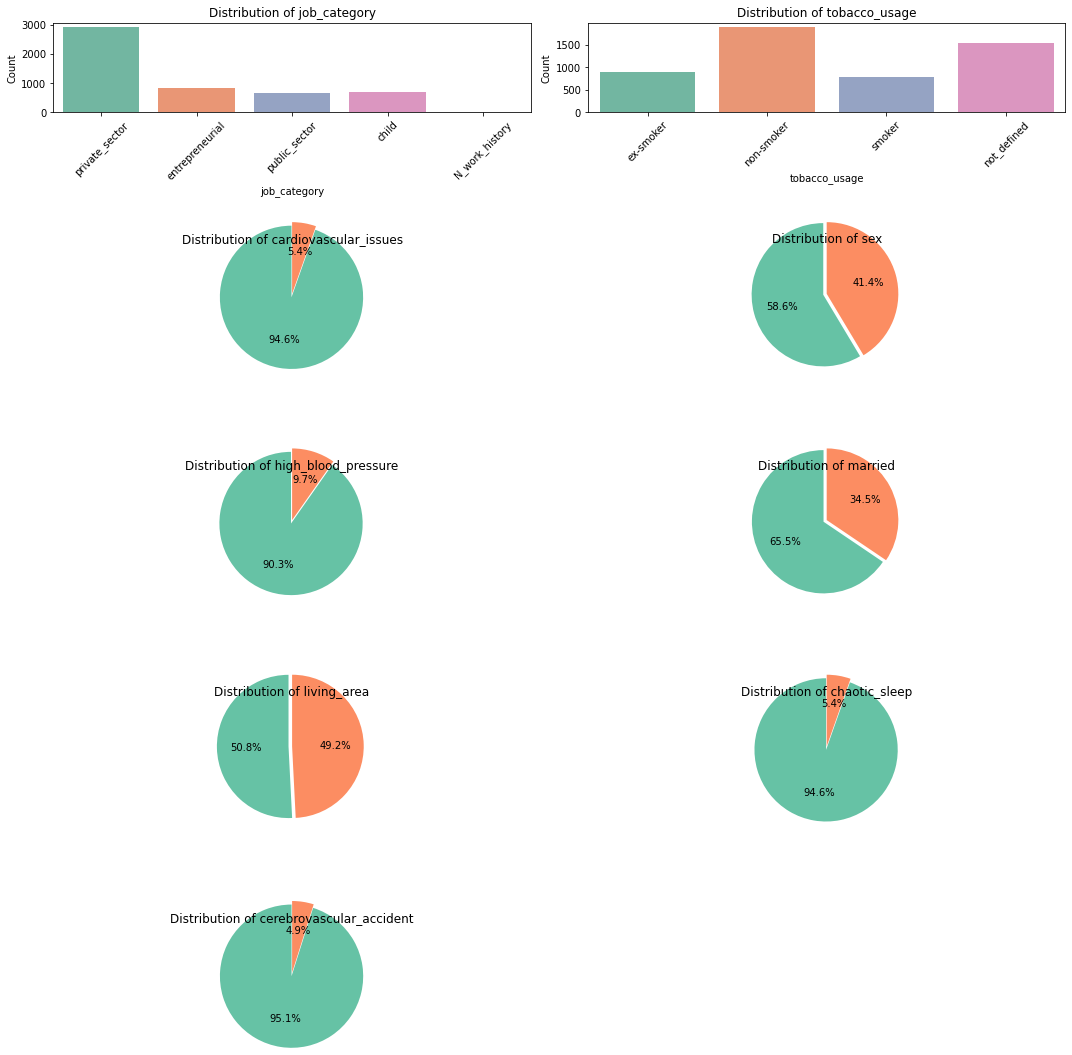

In [1514]:
binary_features = features["binary"]["attributes"]
categorical_features = features["categorical"]["attributes"]

fig, axes = plt.subplots(
    nrows=(len(categorical_features) + len(binary_features) + 1) // 2,
    ncols=2,
    figsize=(15, 3 * (len(categorical_features) + len(binary_features) + 1) // 2)
)

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=avc_df, x=feature, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for i, feature in enumerate(binary_features):
    idx = len(categorical_features) + i
    ax = axes[idx]
    counts = avc_df[feature].value_counts()
    my_xpl = [0.1] + [0.0] * (counts.nunique() - 1)
    wedges, texts, autotexts = ax.pie(
        counts,
        explode=my_xpl,
        autopct='%1.1f%%',
        startangle=90,
        radius=2,
        colors=sns.color_palette("Set2", len(counts))
    )
    ax.set_title(f'Distribution of {feature}')

for j in range(len(categorical_features) + len(binary_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Keypoints
* N_work_history appears a few times in job_category, this may introduce noise when training the model.
* When talking about the health problematic features, like "cardiovascular_issues", "chaotic_sleep" and "high_blood_pressure", we may observe that the majority of data is negative and the percentages of people that suffer from these issues are very similar to those who had cerebrovascular accident, which may imply the importance of these features, as they are highly correlated with the target feature.
* The distribution in living area, sex and marriage is quite balanced.
* The smoking distribution is not telling us much just by looking at this chart.

cerebrovascular_accident
0    1562
1     112
Name: count, dtype: int64


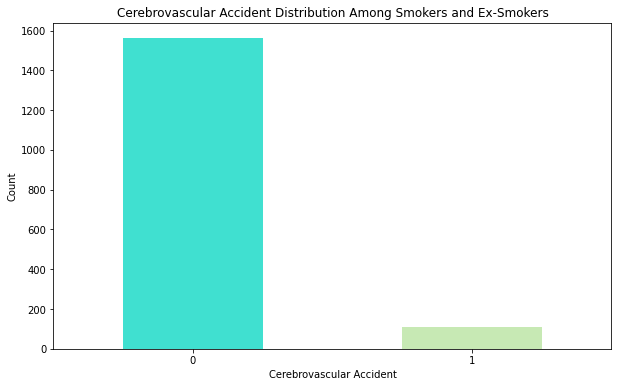

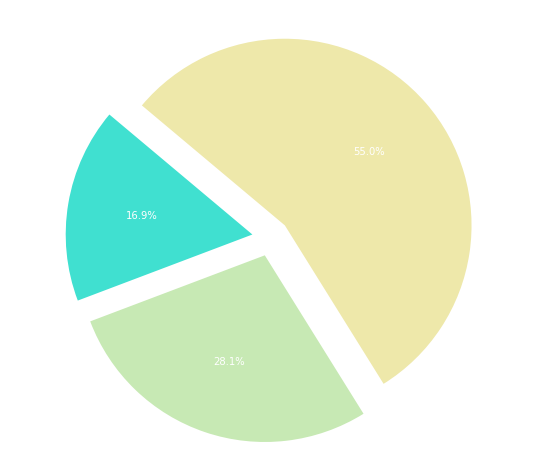

In [1515]:
# Analyze tobacco_usage and cerebrobascular_accident - who smoked and had a cerebrovascular accident
smoked = avc_df[(avc_df["tobacco_usage"] == "ex-smoker") | (avc_df["tobacco_usage"] == "smoker")]

smoker_cva_counts = smoked["cerebrovascular_accident"].value_counts()
print(smoker_cva_counts)

plt.figure(figsize=(10, 6))
smoker_cva_counts.plot(kind='bar', color=['#40E0D0', '#c7e9b4'])
plt.title('Cerebrovascular Accident Distribution Among Smokers and Ex-Smokers')
plt.xlabel('Cerebrovascular Accident')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# How many of those who had CVA were smokers or ex-smokers
cva_cases = avc_df[avc_df["cerebrovascular_accident"] == 1]
smokers_with_cva = cva_cases[(cva_cases["tobacco_usage"] == "ex-smoker") | (cva_cases["tobacco_usage"] == "smoker")]

smokers_with_cva_counts = smokers_with_cva["tobacco_usage"].value_counts()
non_smokers_with_cva_count = len(cva_cases) - len(smokers_with_cva)

labels = ['Smokers', 'Ex-Smokers', 'Non-Smokers']
sizes = [smokers_with_cva_counts.get('smoker', 0), smokers_with_cva_counts.get('ex-smoker', 0), non_smokers_with_cva_count]
colors = ['#40E0D0', '#c7e9b4', '#EEE8AA']
explode = [0.1, 0.1, 0.1] 

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops=dict(color="white"))
plt.title('Distribution of Smokers, Ex-Smokers, and Non-Smokers Among Those Who Had a CVA', color = "white")
plt.axis('equal')
plt.show()

The most important thing to write down here is that half of those who had CVA were smokers or ex-smokers.

### 3.1.2 Correlation Analysis

Even if the preprocessing of data should be done after the correlation analysis, in this dataset there is a lot of binary data, which can simply be converted into 0s and 1s without losing any information.

In [1516]:
# Converting categorical binary to numerical binary
label_encoder = LabelEncoder()
for feature in features["binary"]["attributes"]:
    if type(avc_df[feature][0]) == str:
        avc_df[feature] = label_encoder.fit_transform(avc_df[feature])
        avc_train_df[feature] = label_encoder.fit_transform(avc_train_df[feature])
        avc_test_df[feature] = label_encoder.fit_transform(avc_test_df[feature])

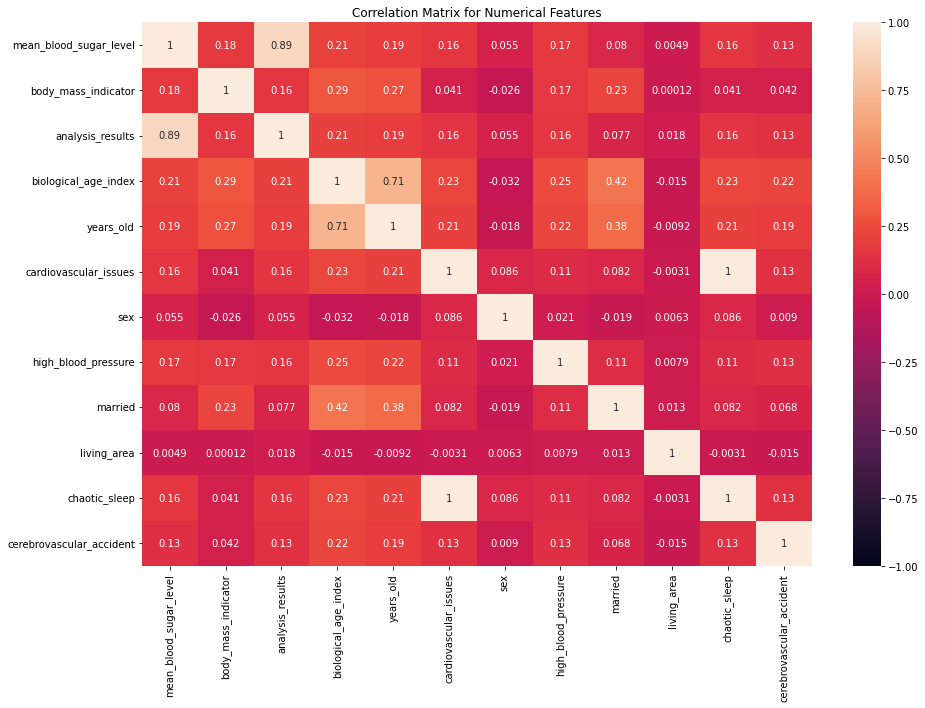

In [1517]:
# Numerical features - including ordinal features
corr_matrix = avc_df[features["numerical"]["attributes"] + features["ordinal"]["attributes"] + features["binary"]["attributes"]].corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

#### Keypoints
* We may observe that chaotic sleep is highly associated with cardiovascular issues, as sleep is very important for the health of the heart.
* Analysis results are highly correlated with mean blood sugar level, this happens because analysis results are based on blood tests, which are influenced by the blood sugar level.
* Years old feature is highly correlated with the biological age index, which is normal, as the biological age index is calculated based on the years old feature and how old the body seems based on biological markers.
* We may also see some moderate correlations between years old and marriage, as people tend to get married at higher ages.

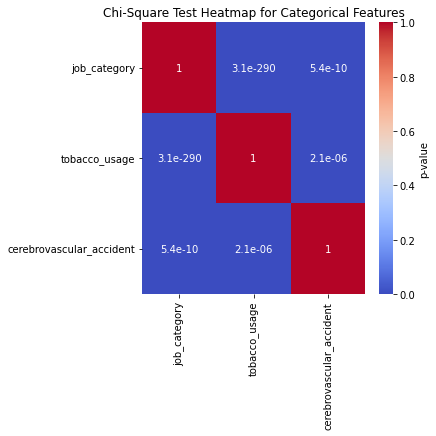

In [1518]:
cat_attributes = features["categorical"]["attributes"] + ["cerebrovascular_accident"]

# chi_square lambda function to be used for finding correlations between categorical features
categorical_corr = pd.DataFrame(np.ones((len(cat_attributes), len(cat_attributes))),
                                index=cat_attributes, columns=cat_attributes)

for f1, f2 in list(filter(lambda f: f[0] != f[1], list(itertools.product(cat_attributes, repeat=2)))):
    categorical_corr.at[f1, f2] = categorical_corr.at[f2, f1] = chi_square(avc_df, f1, f2)

plt.figure(figsize=(5, 5))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'p-value'})
plt.title('Chi-Square Test Heatmap for Categorical Features')
plt.show()


#### Keypoints
* We may see a highly correlation between tobacco usage and job category, which may be true when talking about very stressful jobs but it may also be a coincidence in this dataset.

## 3.2 Data preprocessing

#### 3.2.1 Missing values

There are missing values for "married", "body_mass_indicator" and "analysis_results" features.

In [1519]:
# Using the mean value for body mass indicator and analysis results
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fill the missing values from bmi with mean value
avc_df['body_mass_indicator'] = simple_imputer.fit_transform(avc_df['body_mass_indicator'].values.reshape(-1, 1))
avc_train_df['body_mass_indicator'] = simple_imputer.fit_transform(avc_train_df['body_mass_indicator'].values.reshape(-1, 1))
avc_test_df['body_mass_indicator'] = simple_imputer.fit_transform(avc_test_df['body_mass_indicator'].values.reshape(-1, 1))

# Fill the missing values from analysis results with mean value
avc_df['analysis_results'] = simple_imputer.fit_transform(avc_df['analysis_results'].values.reshape(-1, 1))
avc_train_df['analysis_results'] = simple_imputer.fit_transform(avc_train_df['analysis_results'].values.reshape(-1, 1))
avc_test_df['analysis_results'] = simple_imputer.fit_transform(avc_test_df['analysis_results'].values.reshape(-1, 1))

In [1520]:
# I will drop the rows with missing values from married, as it is a binary feature
avc_df = avc_df.dropna(subset=["married"])
avc_train_df = avc_train_df.dropna(subset=["married"])
avc_test_df = avc_test_df.dropna(subset=["married"])

#### 3.2.2 Extreme values - Outliers

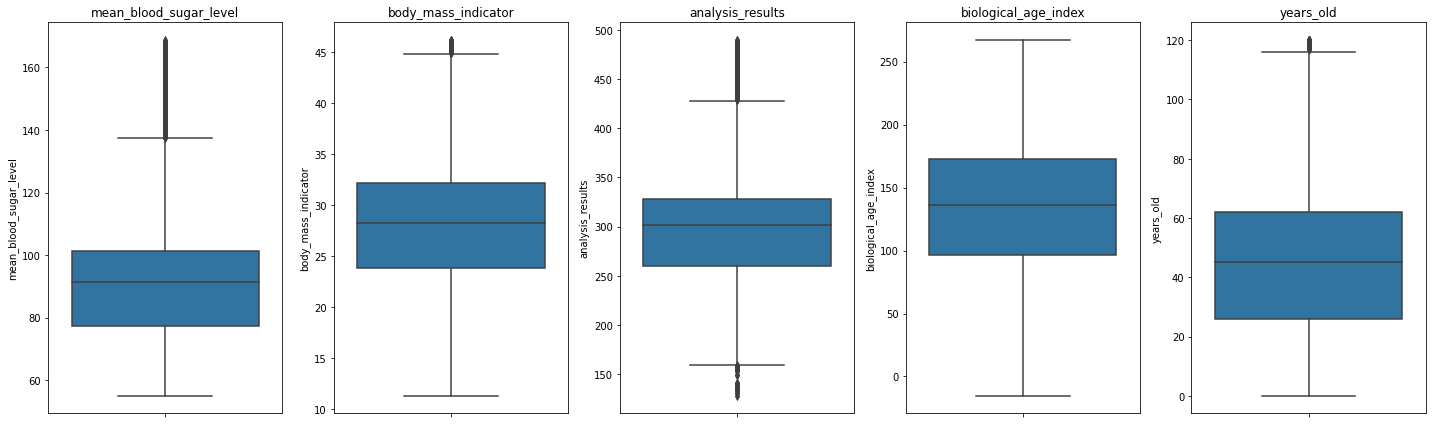

In [1521]:
for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    avc_df = outliers(avc_df, feature)
    avc_train_df = outliers(avc_train_df, feature)
    avc_test_df = outliers(avc_test_df, feature)

print_numerical_features_boxplots(avc_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

#### 3.2.3 Removing the redundant features - strongly correlated features

In [1522]:
removed_numerical_categories = ["mean_blood_sugar_level"]
removed_ordinal_categories = ["years_old"]
removed_binary_categories = ["chaotic_sleep"]

avc_df = avc_df.drop(columns = removed_numerical_categories + removed_binary_categories + removed_ordinal_categories)
avc_train_df = avc_train_df.drop(columns = removed_numerical_categories + removed_binary_categories + removed_ordinal_categories)
avc_test_df = avc_test_df.drop(columns = removed_numerical_categories + removed_binary_categories + removed_ordinal_categories)

features["numerical"]["attributes"] = [feature for feature in features["numerical"]["attributes"] if feature not in removed_numerical_categories]
features["numerical"]["size"] = len(features["numerical"]["attributes"])

features["binary"]["attributes"] = [feature for feature in features["binary"]["attributes"] if feature not in removed_binary_categories]
features["binary"]["size"] = len(features["binary"]["attributes"])

features["ordinal"]["attributes"] = [feature for feature in features["ordinal"]["attributes"] if feature not in removed_ordinal_categories]
features["ordinal"]["size"] = len(features["ordinal"]["attributes"])

#### 3.2.4 Standardization for numerical features

In [1523]:
standard_scaler = StandardScaler()

for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    avc_df[feature] = standard_scaler.fit_transform(avc_df[feature].values.reshape(-1, 1))
    avc_train_df[feature] = standard_scaler.fit_transform(avc_train_df[feature].values.reshape(-1, 1))
    avc_test_df[feature] = standard_scaler.fit_transform(avc_test_df[feature].values.reshape(-1, 1))

#### 3.2.5 Encoding categorical features

In [1524]:
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)
for feature in features["categorical"]["attributes"]:
    if feature in avc_df:
        encoded = one_hot_encoder.fit_transform(avc_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_df = pd.DataFrame(encoded, columns=column_names)
        avc_df = pd.concat([avc_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
        avc_df = avc_df.drop(columns=[feature])

        encoded_train = one_hot_encoder.fit_transform(avc_train_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_train_df = pd.DataFrame(encoded_train, columns=column_names)
        avc_train_df = pd.concat([avc_train_df.reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)
        avc_train_df = avc_train_df.drop(columns=[feature])
        
        encoded_test = one_hot_encoder.fit_transform(avc_test_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_test_df = pd.DataFrame(encoded_test, columns=column_names)
        avc_test_df = pd.concat([avc_test_df.reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)
        avc_test_df = avc_test_df.drop(columns=[feature])
        
for column in avc_df.columns:
    if column not in avc_train_df.columns:
        avc_train_df[column] = 0
    if column not in avc_test_df.columns:
        avc_test_df[column] = 0

# Sort the columns in the same order
avc_train_df = avc_train_df[avc_df.columns]
avc_test_df = avc_test_df[avc_df.columns]

avc_df

,cardiovascular_issues,body_mass_indicator,sex,high_blood_pressure,married,living_area,analysis_results,biological_age_index,cerebrovascular_accident,job_category_child,job_category_entrepreneurial,job_category_private_sector,job_category_public_sector,tobacco_usage_non-smoker,tobacco_usage_not_defined,tobacco_usage_smoker
0,1,1.270001,1,0,1,0,9.090681e-16,0.932690,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.092979,0,0,1,1,9.090681e-16,-0.093152,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0.643825,1,0,1,1,3.499266e-01,1.322113,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,0.934004,0,0,1,0,1.758782e+00,0.734402,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,-0.654345,0,1,1,1,2.386795e+00,1.932687,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0.092979,0,1,1,0,-1.087124e+00,1.511414,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5106,0,1.789269,0,0,1,0,8.679785e-01,1.234930,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5107,0,0.353646,0,0,2,1,-4.769991e-01,-0.437673,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5108,0,-0.409983,1,0,1,1,2.741733e+00,1.081582,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Classifier

In [1525]:
class Classifier:
    def visualize_confusion_matrix(T, Y):
        """
            True negative = (0, 0)
            False negative = (1, 0)
            True positive = (1, 1)
            False positive = (0, 1)            
        """

        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        cm = np.array([[np.sum(idx_tn), np.sum(idx_fp)], [np.sum(idx_fn), np.sum(idx_tp)]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

# Logistic Regression

In [1526]:

class LogisticRegression(Classifier):

    # Logistic sigmoid
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Negative log-likelihood
    def nll(Y, T):
        return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

    # Classification accuracy
    def accuracy(Y, T):
        return np.mean((Y >= 0.5) == T)
    
    # Predict logistic that returns the predictions y for the given input X
    def predict(X, w):
        return LogisticRegression.sigmoid(np.dot(X, w))

    def train_and_eval(X_train, T_train, X_test, T_test, N, D, lr=.01, epochs_no=100):
        w = np.random.randn(D)
        
        train_acc, test_acc = [], []
        train_nll, test_nll = [], []

        predict_logistic = LogisticRegression.predict
        nll = LogisticRegression.nll
        accuracy = LogisticRegression.accuracy

        for epoch in range(epochs_no):
            Y_train = predict_logistic(X_train, w)
            Y_test = predict_logistic(X_test, w)

            train_nll.append(nll(Y_train, T_train))
            train_acc.append(accuracy(Y_train, T_train))
            
            test_nll.append(nll(Y_test, T_test))
            test_acc.append(accuracy(Y_test, T_test))
            
            w -= lr * np.dot(X_train.T, Y_train - T_train) / N
        
        return w, train_nll, test_nll, train_acc, test_acc
    
    def visualize_dataset(X, T, Y=None, w=None, other_w=None):
        m = ["x", "o"]  # Indicates true class
        col = ["red", "blue"]  # Indicates prediction
        fig = plt.figure(); plt.axis('equal')
        if Y is not None:
            idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
            idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
            idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
            idx_tn = np.logical_and(T < .5, Y < .5) # True negatives

            plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
            plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
            plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
            plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

        else:
            idx_pos, idx_neg = (T > .5), (T < .5)
            plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
            plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
        
        if w is not None:
            __x = np.linspace(0, 1, 2)
            __y = -w[0] / w[1] * __x - w[2] / w[1]
            plt.plot(__x, __y, color="black")

        if other_w is not None:
            __x = np.linspace(0, 1, 2)
            __y = -other_w[0] / other_w[1] * __x - other_w[2] / other_w[1]
            plt.plot(__x, __y, color="orange")

        plt.xlabel("x"); plt.ylabel("y")
        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.show()


# Multi-layer Perceptron

In [1527]:
class Mode(Enum):
    SGD = "SGD"
    
class Layer:
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

class MLP(Classifier):
    class FeedForwardNetwork:
        def __init__(self, layers: List[Layer]):
            self.layers = layers
            
        def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
            self._inputs = []
            for layer in self.layers:
                if train:
                    self._inputs.append(x)
                x = layer.forward(x)
            return x
        
        def backward(self, dy: np.ndarray) -> np.ndarray:
            for x, layer in zip(reversed(self._inputs), reversed(self.layers)):
                dy = layer.backward(x, dy)
            return dy
        
        def update(self, *args, **kwargs):
            for layer in self.layers:
                layer.update(*args, **kwargs)
    
    class Linear(Layer):
        def __init__(self, insize: int, outsize: int) -> None:
            bound = np.sqrt(6. / insize)
            self.weight = np.random.uniform(-bound, bound, (insize, outsize))
            self.bias = np.zeros((outsize,))
            
            self.dweight = np.zeros_like(self.weight)
            self.dbias = np.zeros_like(self.bias)
    
        def forward(self, x: np.ndarray) -> np.ndarray:
            self.x = x
            return np.dot(x, self.weight) + self.bias
        
        def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
            self.dweight = np.dot(self.x.T, dy)
            self.dbias = np.sum(dy, axis=0)
            return np.dot(dy, self.weight.T)
        
        def update(self, mode='SGD', lr=0.001, mu=0.9):
            if mode == 'SGD':
                self.weight -= lr * self.dweight
                self.bias -= lr * self.dbias
            else:
                raise ValueError('mode should be SGD, not ' + str(mode))

    class ReLU(Layer):
        def __init__(self) -> None:
            pass
        
        def forward(self, x: np.ndarray) -> np.ndarray:
            return np.maximum(0, x)
        
        def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
            return dy * (x > 0)

    class CrossEntropy:
        def __init__(self):
            pass
        
        def softmax(self, x):
            exps = np.exp(x)
            return exps / np.sum(exps,axis = 1).reshape(-1,1)

        def forward(self, y: np.ndarray, t: np.ndarray) -> float:
            self.y, self.t = y, t
            self.p = self.softmax(y)
            return -np.mean(np.log(self.p[np.arange(len(t)), t]))
        
        def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
            self.p = self.softmax(y)
            self.p[np.arange(len(t)), t] -= 1
            return self.p / len(t)

    def accuracy(y: np.ndarray, t: np.ndarray) -> float:
        return np.mean(np.argmax(y, axis=1) == t)

    def invalid_dataset(train, test, full):
        return train.values() is None or\
                test.values() is None or\
                full.values() is None

    def run(epochs=20,
            batch_size=128,
            hidden_layer_sizes=300,
            mode=Mode.SGD.value,
            lr=.005,
            train={"X": None, "T": None},
            test={"X": None, "T": None},
            full={"X": None, "T": None}
            ):

        if MLP.invalid_dataset(train, test, full):
            print("Invalid dataset. 'None' input.")
            return

        optimize_args = {'mode': mode, 'lr': lr}

        net = MLP.FeedForwardNetwork([MLP.Linear(train["X"].shape[1], hidden_layer_sizes),
                                MLP.ReLU(),
                                MLP.Linear(hidden_layer_sizes, 2)])
        cost_function = MLP.CrossEntropy()

        for epoch in range(epochs):
            for b_no, idx in enumerate(range(0, train["X"].shape[0], batch_size)):
                x = train["X"][idx:idx + batch_size]
                t = train["T"][idx:idx + batch_size]
                
                y = net.forward(x)
                loss = cost_function.forward(y, t)
                dy = cost_function.backward(y, t)
                net.backward(dy)
                
                net.update(**optimize_args)
                
                print(f'\rEpoch {epoch + 1:02d} '
                    f'| Batch {b_no:03d} '
                    f'| Train NLL: {loss:6.3f} '
                    f'| Train Acc: {MLP.accuracy(y, t) * 100:6.2f}% ', end='')

            y = net.forward(test["X"], train=False)
            test_nll = cost_function.forward(y, test["T"])
            print(f'| Test NLL: {test_nll:6.3f} '
                f'| Test Acc: {MLP.accuracy(y, test["T"]) * 100:3.2f}%')
        
        y = net.forward(full["X"], train=False)
        test_nll = cost_function.forward(y, full["T"])
        print(f"\n\nFinal accuracy: {MLP.accuracy(y, full['T'])}")
        
        return y

    

# Apply the algorithms on Salary Classification dataset

In [1528]:
# Add a column of ones to the input data
salary_df = pd.concat([pd.Series(1, index=salary_df.index, name='00'), salary_df], axis=1)
salary_train_df = pd.concat([pd.Series(1, index=salary_train_df.index, name='00'), salary_train_df], axis=1)
salary_test_df = pd.concat([pd.Series(1, index=salary_test_df.index, name='00'), salary_test_df], axis=1)

In [1529]:
# Separate the target feature from the rest of the dataset
X = salary_df.drop(columns=['money'])
T = salary_df['money']

X_train = salary_train_df.drop(columns=['money'])
T_train = salary_train_df['money']

X_test = salary_test_df.drop(columns=['money'])
T_test = salary_test_df['money']

salary_df

,00,fnl,hpw,edu_int,years,loss,gender,prod,money,relation_NotF,...,job_Farming-fishing,job_Handlers-cleaners,job_Machine-op-inspct,job_Other-service,job_Priv-house-serv,job_Prof-specialty,job_Protective-serv,job_Sales,job_Tech-support,job_Transport-moving
0,1,-3.358385e-01,-0.454896,-0.446800,1.762997,0.0,1,1.353672,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.767175e-02,0.000000,1.185176,0.267679,0.0,1,0.928135,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,-3.390974e-01,0.000000,-0.038806,0.192913,0.0,1,2.204746,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-3.024205e-02,-0.454896,-0.446800,-1.003341,0.0,1,0.077061,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3.387426e-16,-0.454896,-1.262788,1.314401,0.0,0,0.289830,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,1,8.454284e-02,-0.454896,-0.446800,1.463933,0.0,1,-1.412318,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9195,1,2.562847e+00,1.054643,-1.262788,-0.330448,0.0,1,0.077061,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9196,1,-1.083127e+00,0.000000,-1.262788,1.987294,0.0,0,1.140904,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9197,1,-1.834118e+00,1.054643,-0.446800,-0.704277,0.0,1,0.289830,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1530]:
salary_df.columns

Index(['00', 'fnl', 'hpw', 'edu_int', 'years', 'loss', 'gender', 'prod',
       'money', 'relation_NotF', 'relation_NotM', 'relation_Other',
       'relation_OwnC', 'relation_W', 'country_United-States',
       'job_Adm-clerical', 'job_Craft-repair', 'job_Exec-managerial',
       'job_Farming-fishing', 'job_Handlers-cleaners', 'job_Machine-op-inspct',
       'job_Other-service', 'job_Priv-house-serv', 'job_Prof-specialty',
       'job_Protective-serv', 'job_Sales', 'job_Tech-support',
       'job_Transport-moving'],
      dtype='object')

### Logistic Regression

Final accuracy - train: 0.8126128628976247, test: 0.8155


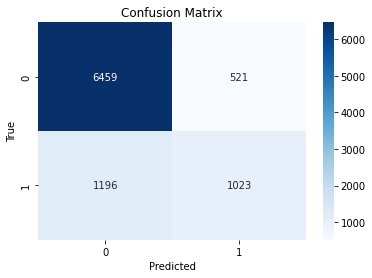

In [1531]:
N_EPOCHS = 1000

(N, D) = X.shape

w, train_nll, test_nll, train_acc, test_acc = LogisticRegression.train_and_eval(X_train, T_train, X_test, T_test, N, D, lr=0.1, epochs_no=N_EPOCHS)

Y = LogisticRegression.predict(X, w)

print(f"Final accuracy - train: {train_acc[-1]}, test: {test_acc[-1]}")
LogisticRegression.visualize_confusion_matrix(T.values, Y)


Scikit-learn final accuracy - train: 0.83053201833588, test: 0.826


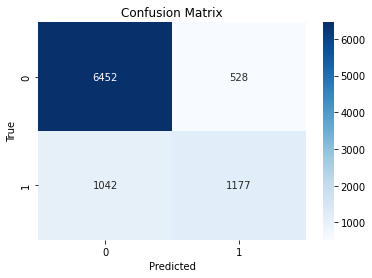

In [1532]:
clf = SKLogisticRegression(random_state=10, max_iter=1000).fit(X_train, T_train)
Y = clf.predict(X)

print(f"Scikit-learn final accuracy - train: {clf.score(X_train, T_train)}, test: {clf.score(X_test, T_test)}")
LogisticRegression.visualize_confusion_matrix(T.values, Y)

### Multi-layer Perceptron

In [1533]:
MLP.run(
    epochs=100,
    batch_size=128,
    hidden_layer_sizes=300,
    mode=Mode.SGD.value,
    lr=.005,
    train={"X": X_train, "T": T_train},
    test={"X": X_test, "T": T_test},
    full={"X": X, "T": T}
)

Epoch 01 | Batch 056 | Train NLL:  0.583 | Train Acc:  77.42% | Test NLL:  0.501 | Test Acc: 76.55%
Epoch 02 | Batch 056 | Train NLL:  0.562 | Train Acc:  80.65% | Test NLL:  0.454 | Test Acc: 79.05%
Epoch 03 | Batch 056 | Train NLL:  0.553 | Train Acc:  77.42% | Test NLL:  0.436 | Test Acc: 79.55%
Epoch 04 | Batch 056 | Train NLL:  0.544 | Train Acc:  74.19% | Test NLL:  0.425 | Test Acc: 80.15%
Epoch 05 | Batch 056 | Train NLL:  0.536 | Train Acc:  74.19% | Test NLL:  0.417 | Test Acc: 80.65%
Epoch 06 | Batch 056 | Train NLL:  0.528 | Train Acc:  74.19% | Test NLL:  0.411 | Test Acc: 81.05%
Epoch 07 | Batch 056 | Train NLL:  0.521 | Train Acc:  74.19% | Test NLL:  0.407 | Test Acc: 81.35%
Epoch 08 | Batch 056 | Train NLL:  0.514 | Train Acc:  74.19% | Test NLL:  0.403 | Test Acc: 81.60%
Epoch 09 | Batch 056 | Train NLL:  0.508 | Train Acc:  74.19% | Test NLL:  0.399 | Test Acc: 82.05%
Epoch 10 | Batch 056 | Train NLL:  0.502 | Train Acc:  74.19% | Test NLL:  0.396 | Test Acc: 82.50%


array([[ 1.98061179, -0.87184736],
       [ 0.15578657,  1.19681109],
       [ 0.50334531,  0.62168763],
       ...,
       [ 1.82977454, -1.84853219],
       [ 0.54834349, -0.78524768],
       [ 0.04069815,  0.65428857]])

Scikit-learn final accuracy - train: 0.8824836782886512, test: 0.824


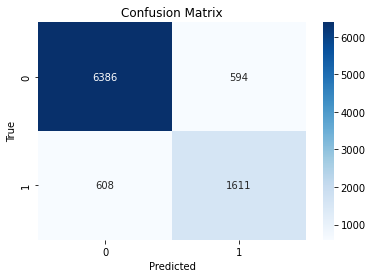

In [1534]:
clf = SKMLPClassifier(random_state=1, max_iter=1000).fit(X_train, T_train)
Y = clf.predict(X)

print(f"Scikit-learn final accuracy - train: {clf.score(X_train, T_train)}, test: {clf.score(X_test, T_test)}")
Classifier.visualize_confusion_matrix(T.values, Y)

# Apply the algorithms on AVC dataset

In [1535]:
# Add a column of ones to the input data
avc_df = pd.concat([pd.Series(1, index=avc_df.index, name='00'), avc_df], axis=1)
avc_train_df = pd.concat([pd.Series(1, index=avc_train_df.index, name='00'), avc_train_df], axis=1)
avc_test_df = pd.concat([pd.Series(1, index=avc_test_df.index, name='00'), avc_test_df], axis=1)

In [1536]:
# Separate the target feature from the rest of the dataset
_X = avc_df.drop(columns=['cerebrovascular_accident'])
_T = avc_df['cerebrovascular_accident']

_X_train = avc_train_df.drop(columns=['cerebrovascular_accident'])
_T_train = avc_train_df['cerebrovascular_accident']

_X_test = avc_test_df.drop(columns=['cerebrovascular_accident'])
_T_test = avc_test_df['cerebrovascular_accident']

avc_df

,00,cardiovascular_issues,body_mass_indicator,sex,high_blood_pressure,married,living_area,analysis_results,biological_age_index,cerebrovascular_accident,job_category_child,job_category_entrepreneurial,job_category_private_sector,job_category_public_sector,tobacco_usage_non-smoker,tobacco_usage_not_defined,tobacco_usage_smoker
0,1,1,1.270001,1,0,1,0,9.090681e-16,0.932690,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0.092979,0,0,1,1,9.090681e-16,-0.093152,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,1,0.643825,1,0,1,1,3.499266e-01,1.322113,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0.934004,0,0,1,0,1.758782e+00,0.734402,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,0,-0.654345,0,1,1,1,2.386795e+00,1.932687,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0.092979,0,1,1,0,-1.087124e+00,1.511414,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5106,1,0,1.789269,0,0,1,0,8.679785e-01,1.234930,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5107,1,0,0.353646,0,0,2,1,-4.769991e-01,-0.437673,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5108,1,0,-0.409983,1,0,1,1,2.741733e+00,1.081582,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Logistic Regression

Final accuracy - train: 0.9569471624266145, test: 0.9266144814090019


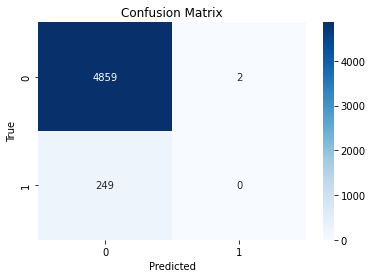

In [1537]:
N_EPOCHS = 1000

(N, D) = _X.shape

w, train_nll, test_nll, train_acc, test_acc = LogisticRegression.train_and_eval(_X_train, _T_train, _X_test, _T_test, N, D, lr=0.1, epochs_no=N_EPOCHS)

Y = LogisticRegression.predict(_X, w)

print(f"Final accuracy - train: {train_acc[-1]}, test: {test_acc[-1]}")
LogisticRegression.visualize_confusion_matrix(_T.values, Y)


Scikit-learn final accuracy - train: 0.9567025440313112, test: 0.9256360078277887


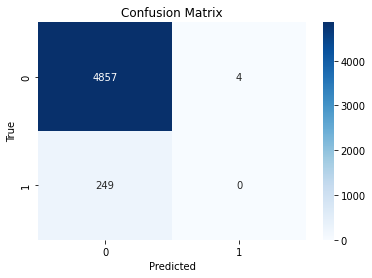

In [1538]:
clf = SKLogisticRegression(random_state=10, max_iter=1000).fit(_X_train, _T_train)
Y = clf.predict(_X)

print(f"Scikit-learn final accuracy - train: {clf.score(_X_train, _T_train)}, test: {clf.score(_X_test, _T_test)}")
LogisticRegression.visualize_confusion_matrix(_T.values, Y)

### Multi-layer Perceptron

In [1542]:
Y = MLP.run(
    epochs=20,
    batch_size=128,
    hidden_layer_sizes=20,
    mode=Mode.SGD.value,
    lr=.001,
    train={"X": _X_train, "T": _T_train},
    test={"X": _X_test, "T": _T_test},
    full={"X": _X, "T": _T}
)

print(Y)
Classifier.visualize_confusion_matrix(_T.values, Y)

Epoch 01 | Batch 031 | Train NLL:  0.626 | Train Acc:  72.50% | Test NLL:  0.682 | Test Acc: 65.66%
Epoch 02 | Batch 031 | Train NLL:  0.562 | Train Acc:  79.17% | Test NLL:  0.609 | Test Acc: 72.21%
Epoch 03 | Batch 031 | Train NLL:  0.510 | Train Acc:  83.33% | Test NLL:  0.551 | Test Acc: 79.75%
Epoch 04 | Batch 031 | Train NLL:  0.468 | Train Acc:  88.33% | Test NLL:  0.505 | Test Acc: 85.13%
Epoch 05 | Batch 031 | Train NLL:  0.434 | Train Acc:  90.00% | Test NLL:  0.467 | Test Acc: 88.45%
Epoch 06 | Batch 031 | Train NLL:  0.407 | Train Acc:  94.17% | Test NLL:  0.437 | Test Acc: 91.39%
Epoch 07 | Batch 031 | Train NLL:  0.384 | Train Acc:  94.17% | Test NLL:  0.412 | Test Acc: 92.17%
Epoch 08 | Batch 031 | Train NLL:  0.365 | Train Acc:  94.17% | Test NLL:  0.392 | Test Acc: 92.37%
Epoch 09 | Batch 031 | Train NLL:  0.349 | Train Acc:  94.17% | Test NLL:  0.375 | Test Acc: 92.47%
Epoch 10 | Batch 031 | Train NLL:  0.335 | Train Acc:  94.17% | Test NLL:  0.360 | Test Acc: 92.66%


ValueError: operands could not be broadcast together with shapes (5110,) (5110,2) 

Scikit-learn final accuracy - train: 0.9713796477495108, test: 0.9168297455968689


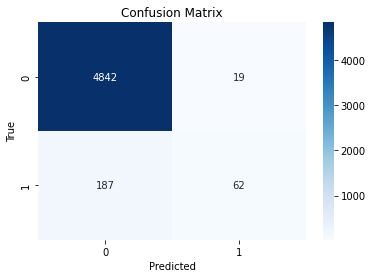

In [ ]:
clf = SKMLPClassifier(
    random_state=1,
    max_iter=1000,
    batch_size=128,
).fit(_X_train, _T_train)
Y = clf.predict(_X)

print(f"Scikit-learn final accuracy - train: {clf.score(_X_train, _T_train)}, test: {clf.score(_X_test, _T_test)}")
Classifier.visualize_confusion_matrix(_T.values, Y)